<a href="https://colab.research.google.com/github/shubhamprakashcolab/Deep-Learning-with-PyTorch-ImageSegmentation_coursera/blob/main/Copy_of_Deep_Learning_with_PyTorch_ImageSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-cka_jsr8
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-cka_jsr8
  Resolved https://github.com/albumentations-team/albumentations to commit 033ab261bb0a702f0350e48a8a07d7c9fecf420b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

fatal: destination path 'Human-Segmentation-Dataset-master' already exists and is not an empty directory.


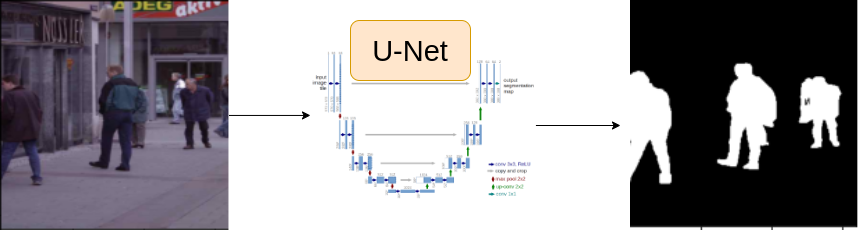

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE = '/content/Human-Segmentation-Dataset-master/train.csv'
IMG_DIR = '/content/Human-Segmentation-Dataset-master/images'

DEVICE = 'cuda'
EPOCHS =25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'time-efficientnet-b0'
WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid'

In [ ]:
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row = df.iloc[0]

image_path = row.images
mask_path = row.masks

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

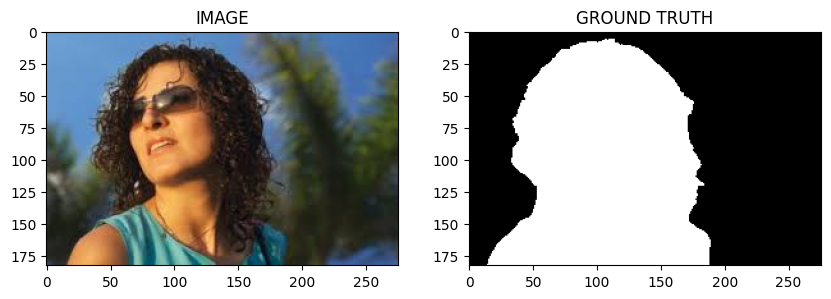

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df,valid_df = train_test_split(df,test_size = 0.2,random_state = 42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE,IMG_SIZE),

  ])

# Task 4 : Create Custom Dataset

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
      return len(self.df)

    def __getitem__(self, idx):

      row = self.df.iloc[idx]

      image_path = row.images
      mask_path = row.masks

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      mask = np.expand_dims(mask, axis=-1)

      if self.augmentations:
        data = self.augmentations(image=image, mask=mask)
        image = data['image']
        mask = data['mask']

      image = np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.Tensor(image)/255.0
      mask = torch.round(torch.Tensor(mask)/255.0)

      return image, mask


In [ ]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augmentations):
        self.df = df
        self.augmentations = augmentations

    def __len__(self):
      return len(self.df)

    def __getitem__(self, idx):

      row = self.df.iloc[idx]

      image_path = row.images
      mask_path = row.masks

      image = cv2.imread(image_path)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

      mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
      mask = np.expand_dims(mask, axis=-1)

      # Ensure image and mask have the same dimensions before augmentation
      if image.shape[:2] != mask.shape[:2]:
          image = cv2.resize(image, mask.shape[:2][::-1])  # Resize image to match mask dimensions

      if self.augmentations:
        data = self.augmentations(image=image, mask=mask)
        image = data['image']
        mask = data['mask']

      image = np.transpose(image, (2,0,1)).astype(np.float32)
      mask = np.transpose(mask, (2,0,1)).astype(np.float32)

      image = torch.Tensor(image)/255.0
      mask = torch.round(torch.Tensor(mask)/255.0)

      return image, mask

In [ ]:
trainset = SegmentationDataset(train_df, get_train_augs())
validset = SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


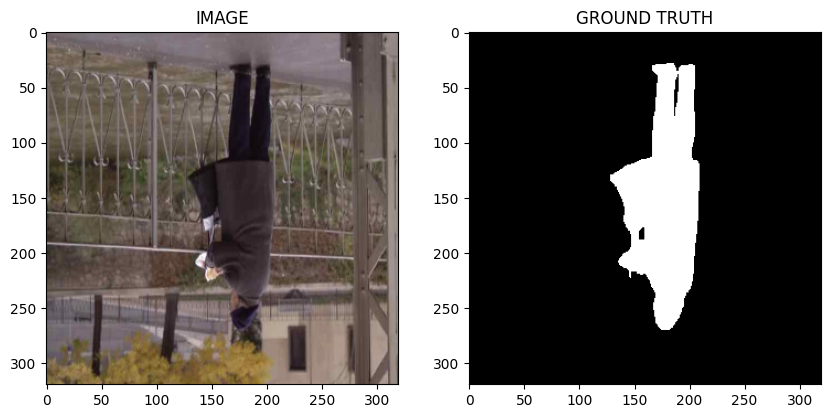

In [ ]:
idx = 4

image, mask = trainset[idx]
helper.show_image(image,mask)

# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset,batch_size = BATCH_SIZE,shuffle = True)
validloader = DataLoader(validset,batch_size = BATCH_SIZE)

In [ ]:
print(f"Size of Trainloader : {len(trainloader)}")
print(f"Size of Validloader : {len(validloader)}")

Size of Trainloader : 15
Size of Validloader : 4


In [ ]:
for image,mask in trainloader:
  print(image.shape)
  print(mask.shape)

torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])
torch.Size([16, 3, 320, 320])
torch.Size([16, 1, 320, 320])
torch.Size([8, 3, 320, 320])
torch.Size([8, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name=ENCODER,
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    def forward(self,images,masks=None):
      logits = self.arc(images)
      if masks != None:
        loss1 = DiceLoss(mode='binary')(logits,masks)
        loss2 = nn.BCEWithLogitsLoss()(logits,masks)
        loss = loss1 + loss2
        return logits,loss

      return logits

In [ ]:
# Add these imports to the top of your script
import segmentation_models_pytorch as smp

# Replace 'time-efficientnet-b0' with a supported encoder.
# A list of supported encoders can be found here:
# https://smp.readthedocs.io/en/latest/encoders_timm.html
ENCODER = 'timm-efficientnet-b0'

WEIGHTS = 'imagenet'  # You may need to specify appropriate weights

class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()

        self.arc = smp.Unet(
            encoder_name=ENCODER,  # Use the corrected encoder name
            encoder_weights=WEIGHTS,
            in_channels=3,
            classes=1,
            activation=None
        )
    def forward(self,images,masks=None):
      logits = self.arc(images)
      if masks != None:
        loss1 = DiceLoss(mode='binary')(logits,masks)
        loss2 = nn.BCEWithLogitsLoss()(logits,masks)
        loss = loss1 + loss2
        return logits,loss

      return logits

In [ ]:
model = SegmentationModel()
model.to(DEVICE)

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
           

# Task 7 : Create Train and Validation Function

In [ ]:
def train_fn(data_loader,model, optimizer):
  model.train()
  total_loss = 0
  for images,masks in tqdm(data_loader):
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits,loss = model(images,masks)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss/len(data_loader)

In [ ]:
def eval_fn(data_loader,model):
  model.eval()
  total_loss = 0
  with torch.no_grad():
    for images,masks in tqdm(data_loader):
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      logits,loss = model(images,masks)

      total_loss += loss.item()

  return total_loss/len(data_loader)

# Task 8 : Train Model

In [ ]:
optimizer = torch.optim.Adam(model.parameters(),lr = LR)

In [ ]:
best_valid_loss = np.Inf
for i in range(EPOCHS):
  train_loss = train_fn(trainloader,model,optimizer)
  valid_loss = eval_fn(validloader,model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(),'best_model.pt')
    print("SAVED THE MODEL")
    best_valid_loss = valid_loss
  print(f"EPOCH : {i+1} TRAIN LOSS : {train_loss} VALID LOSS : {valid_loss}")

100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


SAVED THE MODEL
EPOCH : 1 TRAIN LOSS : 0.26714045107364653 VALID LOSS : 0.20197877287864685


100%|██████████| 4/4 [00:00<00:00,  4.71it/s]


EPOCH : 2 TRAIN LOSS : 0.22554213802019754 VALID LOSS : 0.22542167454957962


100%|██████████| 4/4 [00:00<00:00,  5.54it/s]


EPOCH : 3 TRAIN LOSS : 0.2316198855638504 VALID LOSS : 0.2525218464434147


100%|██████████| 4/4 [00:00<00:00,  5.14it/s]


SAVED THE MODEL
EPOCH : 4 TRAIN LOSS : 0.1701640029748281 VALID LOSS : 0.17843882367014885


100%|██████████| 4/4 [00:00<00:00,  5.50it/s]


EPOCH : 5 TRAIN LOSS : 0.2182775909701983 VALID LOSS : 0.191413301974535


100%|██████████| 4/4 [00:00<00:00,  5.70it/s]


EPOCH : 6 TRAIN LOSS : 0.19069648832082747 VALID LOSS : 0.2057114727795124


100%|██████████| 4/4 [00:02<00:00,  2.00it/s]


EPOCH : 7 TRAIN LOSS : 0.1951591153939565 VALID LOSS : 0.21590329334139824


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


EPOCH : 8 TRAIN LOSS : 0.1644201045234998 VALID LOSS : 0.3267046920955181


100%|██████████| 4/4 [00:01<00:00,  3.99it/s]


EPOCH : 9 TRAIN LOSS : 0.21818842242161432 VALID LOSS : 0.20170431956648827


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


EPOCH : 10 TRAIN LOSS : 0.16687300701936086 VALID LOSS : 0.20481744408607483


100%|██████████| 4/4 [00:00<00:00,  5.57it/s]


EPOCH : 11 TRAIN LOSS : 0.13237889210383097 VALID LOSS : 0.21629565581679344


100%|██████████| 4/4 [00:00<00:00,  4.48it/s]


EPOCH : 12 TRAIN LOSS : 0.1405842622121175 VALID LOSS : 0.1827153880149126


100%|██████████| 4/4 [00:00<00:00,  5.51it/s]


EPOCH : 13 TRAIN LOSS : 0.12994554042816162 VALID LOSS : 0.2065277062356472


100%|██████████| 4/4 [00:00<00:00,  5.40it/s]


EPOCH : 14 TRAIN LOSS : 0.11090858032306035 VALID LOSS : 0.18476445600390434


100%|██████████| 4/4 [00:00<00:00,  5.62it/s]


EPOCH : 15 TRAIN LOSS : 0.09843935618797937 VALID LOSS : 0.19255641102790833


100%|██████████| 4/4 [00:00<00:00,  5.55it/s]


EPOCH : 16 TRAIN LOSS : 0.11733348816633224 VALID LOSS : 0.25025007873773575


100%|██████████| 4/4 [00:01<00:00,  3.70it/s]


EPOCH : 17 TRAIN LOSS : 0.10564488470554352 VALID LOSS : 0.20309427566826344


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


EPOCH : 18 TRAIN LOSS : 0.11631009777386983 VALID LOSS : 0.23807690665125847


100%|██████████| 4/4 [00:01<00:00,  2.34it/s]


EPOCH : 19 TRAIN LOSS : 0.1335323100288709 VALID LOSS : 0.2834296450018883


100%|██████████| 4/4 [00:01<00:00,  2.65it/s]


EPOCH : 20 TRAIN LOSS : 0.14195522020260493 VALID LOSS : 0.23394577950239182


100%|██████████| 4/4 [00:00<00:00,  4.61it/s]


EPOCH : 21 TRAIN LOSS : 0.13811902403831483 VALID LOSS : 0.24483809992671013


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


SAVED THE MODEL
EPOCH : 22 TRAIN LOSS : 0.12678430477778116 VALID LOSS : 0.1784242019057274


100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


EPOCH : 23 TRAIN LOSS : 0.10551480650901794 VALID LOSS : 0.22947748005390167


100%|██████████| 4/4 [00:00<00:00,  5.56it/s]


EPOCH : 24 TRAIN LOSS : 0.09736858109633127 VALID LOSS : 0.19374850764870644


100%|██████████| 4/4 [00:00<00:00,  4.68it/s]

EPOCH : 25 TRAIN LOSS : 0.0938080795109272 VALID LOSS : 0.20040637254714966


# Task 9 : Inference

In [ ]:
idx = 5
model.load_state_dict(torch.load('best_model.pt'))
image,mask = validset[idx]
logits_mask = model(image.to(DEVICE).unsqueeze(0))
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0

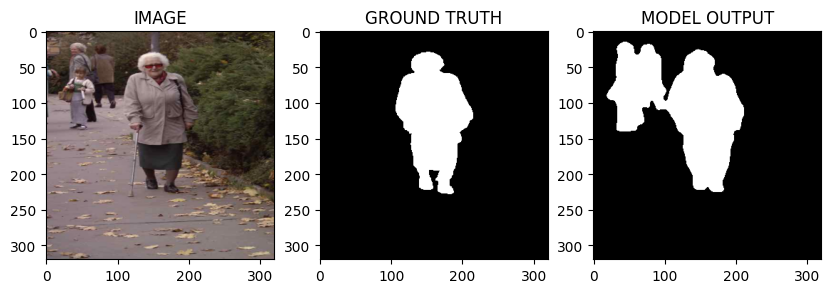

In [ ]:
helper.show_image(image,mask,pred_mask.detach().cpu().squeeze(0))

# For updates about upcoming and current guided projects follow me on...

Twitter : @parth_AI

Linkedin : www.linkedin.com/in/pdhameliya